# Random forst algorithmen based on regression trees - implementation

In [3]:
import numpy as np
import random
import pandas as pd

## Regression trees - implementation

To dos:  
Splitting:  
- option for minimum sample size for split
- option for minimum information gain for split
- spit by minimum SSR of all possible splits
- candidates for the root will be decided via min SSR

Evaluation:  
- average of values in note level

### Helper functions

This function evaluates the effectiveness of a splitting candidate by calculating a specified metric for two subsets of data based on the given method.

In [4]:
def evaluate(subset1, subset2, method):
    if method == "min. MSR":
        predictor1 = subset1.mean()
        predictor2 = subset2.mean()
        
        SSR1 = ((subset1 - predictor1) ** 2).sum() 
        SSR2 = ((subset2 - predictor2) ** 2).sum()
        MSR = (SSR1 + SSR2)/ (len(subset1) + len(subset2))
        return MSR
    else:
        print("Error! ", method, " is not a method!")

This function identifies the best splitting candidate for the first column of a dataset by evaluating the effectiveness of splits on the second column, based on a specified evaluation method and optimization criterion (e.g., minimizing MSR).

In [5]:
def set_optimize_best_evaluation(method):
    if (method == "min. MSR"):
        optimize = "min"
        best_evaluation = float("inf")

    elif (method == "???"):
        optimize = "max"
        best_evaluation = float("-inf")
        
    else:
        print("ERROR! ", method, " is not a implemented method!")
        method = "min. MSR"
        optimize = "min"
        best_evaluation = float("inf")
    
    return optimize, best_evaluation

In [6]:
def RT_univariate_split(independent_variable, dependent_variable, method = "min. MSR"):
    
    #print("DEBUG: type(independent_variable) is \n", type(independent_variable), "\n")

    if isinstance(independent_variable, pd.DataFrame):
        independent_variable = independent_variable.iloc[:, 0]
        #print("DEBUG: type(independent_variable) is \n", type(independent_variable), "\n")
    
    candidates = [
        x for x in independent_variable.unique() 
    ]
    ##print("DEBUG: candidates is \n", candidates, "\n")
    

    optimize, best_evaluation = set_optimize_best_evaluation(method)

    best_candidate = None
    min_split_size = 0
    
    for candidate in candidates:
        ##print("DEBUG: candidate set to \n", candidate, "\n")

        subset1 = dependent_variable[independent_variable < candidate]
        subset2 = dependent_variable[independent_variable >= candidate]
        #print("DEBUG: subset1 set to \n", subset1, "\n")
        #print("DEBUG: subset2 set to \n", subset2, "\n")
        #print("DEBUG: type(subset1) set to \n", type(subset1), "\n")
        #print("DEBUG: type(subset2) set to \n", type(subset2), "\n")

        subset1 = subset1.iloc[:, 0]
        subset2 = subset2.iloc[:, 0]
        #print("DEBUG: subset1 set to \n", subset1, "\n")
        #print("DEBUG: subset2 set to \n", subset2, "\n")
        #print("DEBUG: type(subset1) set to \n", type(subset1), "\n")
        #print("DEBUG: type(subset2) set to \n", type(subset2), "\n")

        min_split_size = min(len(subset1), len(subset2))

        candidate_evaluation = evaluate(subset1, subset2, method)
        ##print("DEBUG: candidate_evaluation set to \n", candidate_evaluation, "\n")

        if optimize == "min":

            ##print("DEBUG: best_evaluation is \n", best_evaluation, "\n")
            if candidate_evaluation < best_evaluation:
                best_evaluation = candidate_evaluation
                best_candidate = candidate
                ##print("DEBUG: best_candidate set to \n", best_candidate, "\n")
        else:
            if candidate_evaluation > best_evaluation:
                best_evaluation = candidate_evaluation
                best_candidate = candidate
                ##print("DEBUG: best_candidate set to \n", best_candidate, "\n")

    return best_candidate, best_evaluation, min_split_size

In [18]:
def RT_split(independent_variables, dependent_variable, method = "min. MSR", random_feature_count = None):
    

    optimize, best_evaluation = set_optimize_best_evaluation(method)
    best_column = None
    best_candidate = None

    split_results = {}
    
    feature_columns = independent_variables.columns
    ##print("DEBUG: feature_columns set to \n", feature_columns, "\n")
    if random_feature_count:
        if random_feature_count >= len(feature_columns):
            #print("Warning! Not enough features! Deactivate random feature selection.")
            random_feature_count = None
        elif not isinstance(random_feature_count, int) or random_feature_count < 1:
            #print("DEBUG: isinstance(random_feature_count, int) is set to \n", isinstance(random_feature_count, int), "\n")
            #print("DEBUG: random_feature_count is set to \n", random_feature_count, "\n")
            #print("Warning! random_feature_count must be int and >= 1! Deactivate random feature selection.")
            random_feature_count = None

    if random_feature_count:
        feature_columns = random.sample(list(feature_columns), random_feature_count)
        #print("DEBUG: feature_columns set to \n", feature_columns, "\n")

    for col in feature_columns:
        #print("DEBUG: len(indep) set to: \n", len(independent_variables), "\n")
        candidate, evaluation, min_split_size = RT_univariate_split(independent_variables[col], dependent_variable, method)
        split_results[col] = {"candidate": candidate, "evaluation": evaluation}
        print("DEBUG: split_results[", col, "] set to \n", split_results[col], "\n")

        if optimize == "min":
            for col, result in split_results.items():
                if result["evaluation"] < best_evaluation:
                    best_evaluation = result["evaluation"]
                    best_column = col
                    best_candidate = result["candidate"]
        else:
            for col, result in split_results.items():
                if result["evaluation"] > best_evaluation:
                    best_evaluation = result["evaluation"]
                    best_column = col
                    best_candidate = result["candidate"]

    return best_column, best_candidate, best_evaluation, min_split_size

In [8]:
def subset_data(data, dependent_column):
    dependent_variable = data[[dependent_column]]
    independent_variables = data.drop(columns=[dependent_column])
    return independent_variables, dependent_variable

In [24]:
def RT_recursion(independent_variables, dependent_variable,  # data inputs
                 method="min. MSR",  # evaluation specification
                 random_feature_count=None,  # sampling methods
                 min_evaluation_gain=0, min_leaf_size=1,  # split stopping condition
                 max_depth=20, max_splits=100,  # universal stopping conditions
                 depth=0, num_splits=0, len_dep=float('inf'), optimize = True, best_evaluation = None  # recursion passes
                 ):
    #initialize in first recursive step
    if best_evaluation is None:
        optimize, best_evaluation = set_optimize_best_evaluation(method)
    
    #recursion break
    if len(dependent_variable) <= min_leaf_size or len(dependent_variable) >= len_dep or depth >= max_depth or num_splits >= max_splits:
        return None

    #determine the best split
    column, candidate, evaluation, min_split_size = RT_split(independent_variables, dependent_variable, method, random_feature_count)

    #break if invalid split
    if column is None or candidate is None:
        return None
    
    #evaluation gain breaking condition
    print("DEBUG: best_evaluation is: \n", best_evaluation, "\n")
    if min_evaluation_gain != 0:
        
        if optimize == "min":
            
            with np.errstate(divide='ignore', invalid='ignore'):
                evaluation_gain = best_evaluation / evaluation -1
                print("DEBUG: evaluation_gain set to \n", evaluation_gain, "\n")
                best_evaluation = evaluation
                print("DEBUG: best_evaluation set to \n", best_evaluation, "\n")
            
        else:
            with np.errstate(divide='ignore', invalid='ignore'):
                evaluation_gain = evaluation / best_evaluation - 1  
                best_evaluation = evaluation

        if evaluation_gain < min_evaluation_gain:
            return None

    #subset
    indep_subset_left = independent_variables[independent_variables[column] < candidate]
    indep_subset_right = independent_variables[independent_variables[column] >= candidate]
    dep_subset_left = dependent_variable[independent_variables[column] < candidate]
    dep_subset_right = dependent_variable[independent_variables[column] >= candidate]

    print("DEBUG: indep_subset_left set to: \n", indep_subset_left, "\n")
    print("DEBUG: indep_subset_right set to: \n", indep_subset_right, "\n")
    #update recursion counters
    depth += 1
    num_splits += 1

    #recursive calls with updated depth and splits
    left_results = None
    right_results = None

    if len(dep_subset_left) >= min_leaf_size:
        left_results = RT_recursion(indep_subset_left, dep_subset_left,
                                    method, random_feature_count,
                                    min_evaluation_gain, min_leaf_size,
                                    max_depth, max_splits,
                                    depth, num_splits, len(dependent_variable), optimize, best_evaluation)

    if len(dep_subset_right) >= min_leaf_size:
        right_results = RT_recursion(indep_subset_right, dep_subset_right,
                                     method, random_feature_count,
                                     min_evaluation_gain, min_leaf_size,
                                     max_depth, max_splits,
                                     depth, num_splits, len(dependent_variable), optimize, best_evaluation)

    return [(column, candidate), left_results, right_results]


### Tree testing

In [25]:
data1 = pd.DataFrame({
    "Bedrooms": [2, 3, 4, 5, 3, 4, 2, 3],
    "Square Footage": [1500, 1800, 2200, 2000, 2500, 2300, 1600, 1900],
    "Age": [20, 15, 25, 10, 5, 8, 30, 12],
    "Price": [250, 300, 300, 320, 500, 450, 350, 350]
})

data2 = pd.DataFrame({
    "Bedrooms": [2, 3, 4, 3, 5, 4, 2, 3],
    "Price": [250, 300, 400, 320, 500, 450, 200, 350]
})

data3 = pd.DataFrame({
    "Bedrooms": [3, 4],
    "Square Footage": [2500, 2300],
    "Age": [5, 8],
    "Price": [500, 450]
})
independent_variables, dependent_variable = subset_data(data1, "Price")
#print(independent_variables)

#print("Result of evaluate function:", evaluate(subset1, subset2, method="min. MSR"))
#print(RT_univariate_split(independent_variables, dependent_variable))
#print(RT_split(independent_variables, dependent_variable, random_feature_count = 2))
print(RT_recursion(independent_variables, dependent_variable, min_evaluation_gain=0.2))


DEBUG: split_results[ Bedrooms ] set to 
 {'candidate': 3, 'evaluation': 5125.0} 

DEBUG: split_results[ Square Footage ] set to 
 {'candidate': 2300, 'evaluation': 1041.6666666666667} 

DEBUG: split_results[ Age ] set to 
 {'candidate': 10, 'evaluation': 1041.6666666666667} 

DEBUG: best_evaluation is: 
 inf 

DEBUG: evaluation_gain set to 
 inf 

DEBUG: best_evaluation set to 
 1041.6666666666667 

DEBUG: indep_subset_left set to: 
    Bedrooms  Square Footage  Age
0         2            1500   20
1         3            1800   15
2         4            2200   25
3         5            2000   10
6         2            1600   30
7         3            1900   12 

DEBUG: indep_subset_right set to: 
    Bedrooms  Square Footage  Age
4         3            2500    5
5         4            2300    8 

DEBUG: split_results[ Bedrooms ] set to 
 {'candidate': 3, 'evaluation': 1112.5} 

DEBUG: split_results[ Square Footage ] set to 
 {'candidate': 1600, 'evaluation': 420.0} 

DEBUG: split_resu

### Explaination of the output structure
with this input:  
indep_vars = pd.DataFrame({  
    "Bedrooms": [2, 3, 4, 5, 3, 4, 2, 3],  
    "Square Footage": [1500, 1800, 2200, 2000, 2500, 2300, 1600, 1900],  
    "Age": [20, 15, 25, 10, 5, 8, 30, 12]  
})  

dep_var = pd.DataFrame({  
    "Price": [250, 300, 300, 320, 500, 450, 350, 350]  
})  

one obtains this tree output:  
[('Square Footage', 2300), [('Square Footage', 1600), None, [('Bedrooms', 3), None, None]], [('Bedrooms', 4), None, None]]  

which must be understood as this tree: (diagram by ChatGPT)

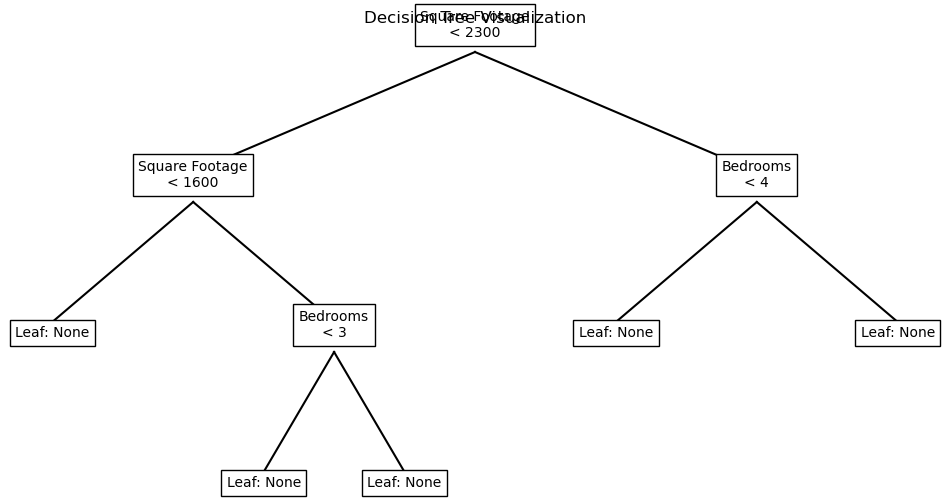

In [11]:
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd

# Create a mock tree representation based on the description
# Node Structure: Feature, Threshold, and Leaf indicators
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left  # Left Node (if any)
        self.right = right  # Right Node (if any)

# Manually define the decision tree structure
root = Node("Square Footage", 2300,
            left=Node("Square Footage", 1600,
                      left=Node("Leaf: None"),
                      right=Node("Bedrooms", 3,
                                 left=Node("Leaf: None"),
                                 right=Node("Leaf: None"))),
            right=Node("Bedrooms", 4,
                       left=Node("Leaf: None"),
                       right=Node("Leaf: None")))

# Function to recursively visualize the decision tree
def plot_tree(node, depth=0, pos=(0.5, 1), parent=None, level_width=0.5, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.axis("off")
        ax.set_title("Decision Tree Visualization")

    # Draw the current node
    if node:
        x, y = pos
        node_text = f"{node.feature}\n< {node.threshold}" if node.feature and node.threshold else node.feature
        ax.text(x, y, node_text, ha="center", bbox=dict(facecolor="white", edgecolor="black"))
        
        # Recursively plot left and right branches
        if node.left:
            new_x = x - level_width / (2 ** depth)
            new_y = y - 0.1
            ax.plot([x, new_x], [y - 0.01, new_y + 0.01], color="black")
            plot_tree(node.left, depth + 1, pos=(new_x, new_y), parent=pos, ax=ax)

        if node.right:
            new_x = x + level_width / (2 ** depth)
            new_y = y - 0.1
            ax.plot([x, new_x], [y - 0.01, new_y + 0.01], color="black")
            plot_tree(node.right, depth + 1, pos=(new_x, new_y), parent=pos, ax=ax)

    return ax

# Visualize the manually created tree
plot_tree(root)
plt.show()


In [12]:
def regression_forest(independent_variables, dependent_variable,  # data inputs
                num_trees = 1, # forest specifications
                method="min. MSR",  # evaluation specification
                random_feature_count=None, bootstrap_count=None,  # sampling methods
                min_evaluation_gain=0, min_leaf_size=1,  # split stopping condition
                max_depth=20, max_splits=100,  # universal stopping conditions
                ):
    
    model = []
    for i in range(num_trees):
        #bootstrapping
        if bootstrap_count is not None and bootstrap_count > 0:
            sampled_independent = independent_variables.sample(n=bootstrap_count, replace=True)
            sampled_dependent = dependent_variable.loc[sampled_independent.index]
        else:
            sampled_independent = independent_variables
            sampled_dependent = dependent_variable
        
        tree = RT_recursion(sampled_independent, sampled_dependent,
                                 method,  # evaluation specification
                                 random_feature_count,  # sampling methods
                                 min_evaluation_gain, min_leaf_size,  # split stopping condition
                                 max_depth, max_splits,  # universal stopping conditions
                                 )

        model.append(tree)
    

    return model

print(regression_forest(independent_variables, dependent_variable, num_trees = 2, min_leaf_size = 2))

DEBUG: len(indep) set to: 
 8 

DEBUG: split_results[ Bedrooms ] set to 
 {'candidate': 3, 'evaluation': 5125.0} 

DEBUG: len(indep) set to: 
 8 

DEBUG: split_results[ Square Footage ] set to 
 {'candidate': 2300, 'evaluation': 1041.6666666666667} 

DEBUG: len(indep) set to: 
 8 

DEBUG: split_results[ Age ] set to 
 {'candidate': 10, 'evaluation': 1041.6666666666667} 

DEBUG: indep_subset_left set to: 
    Bedrooms  Square Footage  Age
0         2            1500   20
1         3            1800   15
2         4            2200   25
3         5            2000   10
6         2            1600   30
7         3            1900   12 

DEBUG: indep_subset_right set to: 
    Bedrooms  Square Footage  Age
4         3            2500    5
5         4            2300    8 

DEBUG: len(indep) set to: 
 6 

DEBUG: split_results[ Bedrooms ] set to 
 {'candidate': 3, 'evaluation': 1112.5} 

DEBUG: len(indep) set to: 
 6 

DEBUG: split_results[ Square Footage ] set to 
 {'candidate': 1600, 'evalu